In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
import pandas as pd
from arch import arch_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score, mean_absolute_error
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K


In [2]:
def read_data(window=22):
    price = pd.read_csv('dataset/kospi.csv')
    oil = pd.read_csv('dataset/oilprice.csv')
    gold = pd.read_csv('dataset/goldprice.csv')
    data = pd.DataFrame()
    data['Date'] = price['Date']
    data['Daily_trading_range'] = price['High'] - price['Low']
    data['Log_Volume_change'] = np.log((price['Volume'] / price['Volume'].shift(1))) * 100
    data['Daily_return'] = price['Close'].pct_change().dropna()
    data['Daily_log_return'] = np.log(price['Close'] / price['Close'].shift(1))
    data['Index'] = price['Close']
    data['gold'] = gold['Close']
    data['oil'] = oil['Close']
    data = data.dropna().reset_index(drop=True)

    data = data.iloc[:-window]
    print(data['Daily_log_return'])
    volatility = np.sqrt((data['Daily_log_return'] ** 2).rolling(window=window).sum() / window) * np.sqrt(252)

    # target = yz_vol_measure(data)
    # target10 = yz_vol_measure(data, window=10)
    target = pd.DataFrame()
    target['Target'] = volatility[window:].reset_index(drop=True)
    target = target.dropna()

    # data['Target10'] = target10
    # data = data.dropna()

    return data, target

In [3]:
def evaluate(predict, target, title):
    print('--------'+title+'----------')
    testScore = mean_squared_error(predict, target)
    print("test Score: {score} MSE".format(score=testScore))
    root_testScore = mean_squared_error(y_pred=predict, y_true=target, squared=False)
    print("test Score: {score} RMSE".format(score=root_testScore))
    mape = mean_absolute_percentage_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAPE".format(score=mape))
    mae = mean_absolute_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAE".format(score=mae))
    r2_test = r2_score(y_true=target, y_pred=predict)
    print("test Score: {score} R2 score".format(score=r2_test))

In [60]:
def plot(predict, target, title, save=False):
    plt.plot(predict, label='predict')
    plt.plot(target, label='target')
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig('images/'+title)
    plt.show()

In [6]:
def ewma_estimation(data):
    sqreturn = np.array(data['Daily_log_return']**2)
    estimation = []
    estimation.append(data['Past_vol22'].iloc[0] / np.sqrt(252))
    weight = 0.94
    for i in range(1,len(data)):
        pred = weight*(estimation[-1]**2) + (1-weight)*(sqreturn[i-1])
        estimation.append(np.sqrt(pred))

    estimation = np.sqrt(252)*pd.DataFrame(estimation, columns=['EWMA'])

    # plot(estimation, np.array(data['Target22']))
    print('-----EWMA estimation done-----')
    return estimation

In [22]:
def create_gjr(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']].dropna())
    print(len(logreturns))
    gjr_pred = []
    for i in range(len(logreturns)-window):
        train = logreturns[:i+window] * 100
        gm = arch_model(train, p=1, q=1, o=1)
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        gjr_pred.append(np.sqrt(pred.variance.values[-1, :].mean()) * 0.01 * np.sqrt(252))

    print('garch pred length: ', len(gjr_pred))
    print('target length: ', len(target))
    title = 'GARCH prediction, window={}, n_ahead={}'.format(window, n_ahead)
    plot(gjr_pred, target, title)
    gjr_pred = pd.DataFrame(gjr_pred, columns=['GJR'])
    print('-----GJR-GARCH estimation done-----')
    return gjr_pred

In [23]:
def create_garch(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']])
    print(len(logreturns))
    garch_pred = []
    for i in range(len(logreturns)-window):
        train = logreturns[:i+window]*100
        gm = arch_model(train, p=1, q=1)
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        garch_pred.append(np.sqrt(pred.variance.values[-1,:].mean())*0.01*np.sqrt(252))

    print('garch pred length: ', len(garch_pred))
    print('target length: ', len(target))
    title = 'GARCH prediction, window={}, n_ahead={}'.format(window, n_ahead)
    plot(garch_pred, target, title)
    garch_pred = pd.DataFrame(garch_pred, columns=['GARCH'])
    print('-----GARCH estimation done-----')
    return garch_pred

In [9]:
def data_prep(data, target, split_index, status=0, n_ahead=1, window=22):
    extras=pd.DataFrame()

    data = data.drop(['Daily_return','Date'], axis=1)

    window = window
    n_ahead = n_ahead
    y_values = target
    x_values = data
    print(x_values.info())

    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(x_values)
    scaled_y = scaler.fit_transform(y_values)

    if(status==1):
        extras['GARCH'] = data['GARCH'].dropna()

    elif(status==2):
        extras['GJR'] = data['GJR'].dropna()

    elif(status==3):
        extras['GARCH'] = data['GARCH'].dropna()
        extras['GJR'] = data['GJR'].dropna()

    trainX = np.array(scaled_x[:split_index])
    testX = np.array(scaled_x[split_index:])
    trainY = np.array(scaled_y[:split_index])
    testY = np.array(scaled_y[split_index:])

    Xtrain = np.array([])
    ytrain = np.array([])
    Xtest = np.array([])
    ytest = np.array([])

    for i in range(window, len(trainX)-n_ahead-window):
        candidate = trainX[i - window:i, :trainX.shape[1]]
        if(status==1):
            candidate[:,-1] = extras['GARCH'].iloc[i-window]
        elif(status==2):
            candidate[:,-1] = extras['GJR'].iloc[i-window]
        elif(status==3):
            candidate[:,-1] = extras['GARCH'].iloc[i-window]
            candidate[:,-2] = extras['GJR'].iloc[i-window]

        candidate = candidate.reshape(1, candidate.shape[0], candidate.shape[1])
        y_candidate = trainY[i-window:i-window+n_ahead].reshape(1, trainY[i-window:i-window+n_ahead].shape[0], trainY[i:i+n_ahead].shape[1])

        if i==window:
            Xtrain = candidate
            ytrain = y_candidate
            continue

        Xtrain = np.append(Xtrain, candidate, axis=0)
        ytrain = np.append(ytrain, y_candidate, axis=0)
        # ytrain.append(trainY[i:i+n_ahead])

    for i in range(window, len(testX)-n_ahead-window):
        test_candidate = testX[i - window:i, :testX.shape[1]]
        if(status==1):
            test_candidate[:,-1] = extras['GARCH'].iloc[split_index+i-window]
        elif(status==2):
            test_candidate[:,-1] = extras['GJR'].iloc[split_index+i-window]
        elif(status==3):
            test_candidate[:,-1] = extras['GARCH'].iloc[split_index+i-window]
            test_candidate[:,-2] = extras['GJR'].iloc[split_index+i-window]
        test_candidate = test_candidate.reshape(1, test_candidate.shape[0], test_candidate.shape[1])
        test_y_can = testY[i-window:i-window+n_ahead].reshape(1, testY[i-window:i-window+n_ahead].shape[0], testY[i-window:i-window+n_ahead].shape[1])

        if(i==window):
            Xtest = test_candidate
            ytest = test_y_can
            continue
        Xtest = np.append(Xtest, test_candidate, axis=0)
        ytest = np.append(ytest, test_y_can, axis=0)

        # Xtest.append(test_candidate)
        # ytest.append(testY[i:i+n_ahead])
    # Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
    # Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))
    #
    # Xtest, ytest = (np.array(Xtest), np.array(ytest))
    # Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

    print(Xtrain.shape)
    print(ytrain.shape)
    print("-----")
    print(Xtest.shape)
    print(ytest.shape)
    return Xtrain, ytrain, Xtest, ytest, scaler

In [43]:
def create_lstm(dropout1=0, output=1):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dropout(dropout1))
    # model.add(LSTM(units=32, return_sequences=False))
    # model.add(Dropout(dropout2))
    # model.add(LSTM(units=20, return_sequences=False))
    # model.add(Dropout(dropout3))
    # model.add(Dense(20, activation='tanh'))
    model.add(Dense(output))
    # model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mae', optimizer=opt)

    return model

In [11]:
def create_ann(output=1):
    model = Sequential()
    model.add(Flatten(input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(output))
    adam = Adam(learning_rate=0.001)
    model.compile(loss='mae', optimizer=adam)
    return model

In [12]:
def run_lstm(Xtrain, ytrain, Xtest, ytest, scaler):
    lstm = create_lstm(Xtrain)
    lstm_fit = lstm.fit(Xtrain, ytrain, batch_size=16, epochs=150)
    lstm_forecast = lstm.predict(Xtest)

    rev_forecast = scaler.inverse_transform(lstm_forecast)
    rev_ytest = scaler.inverse_transform(ytest)

    plot(rev_forecast, rev_ytest)
    evaluate(rev_forecast, rev_ytest, 'LSTM Evaluation')

In [13]:
def run_ann(Xtrain, ytrain, Xtest, ytest, scaler):
    model = create_ann(Xtrain)
    model_fit = model.fit(Xtrain, ytrain, batch_size=16, epochs=50)
    forecast = model.predict(Xtest)

    rev_forecast = scaler.inverse_transform(forecast)
    rev_ytest = scaler.inverse_transform(ytest)

    plt.plot(rev_forecast, color='red', label='forecast')
    plt.plot(rev_ytest, color='gold', label='target')
    plt.legend()
    plt.show()
    evaluate(rev_forecast, rev_ytest, 'GER-FNN evaluation')

In [14]:
data, target = read_data(22)

split_index = int(len(data)*0.8)
split_index

0       0.007249
1      -0.001243
2      -0.002375
3       0.004126
4      -0.002587
          ...   
2400    0.019042
2401    0.005812
2402   -0.006215
2403    0.009324
2404    0.002867
Name: Daily_log_return, Length: 2405, dtype: float64


1924

In [15]:
data

,Date,Daily_trading_range,Log_Volume_change,Daily_return,Daily_log_return,Index,gold,oil
0,2011-01-04,16.019776,16.086549,0.007275,0.007249,2085.139893,1388.500000,88.000000
1,2011-01-05,10.219971,-7.434844,-0.001242,-0.001243,2082.550049,1405.400024,89.190002
2,2011-01-06,30.549804,5.468045,-0.002372,-0.002375,2077.610107,1415.300049,89.379997
3,2011-01-07,17.540039,-19.485688,0.004134,0.004126,2086.199951,1408.300049,88.690002
4,2011-01-10,19.339844,2.064361,-0.002584,-0.002587,2080.810059,1382.500000,88.279999
...,...,...,...,...,...,...,...,...
2400,2020-11-23,51.880127,37.886469,0.019225,0.019042,2602.590088,2001.199951,41.700001
2401,2020-11-24,23.489991,-18.932034,0.005829,0.005812,2617.760010,2031.099976,42.189999
2402,2020-11-25,58.850098,3.287256,-0.006196,-0.006215,2601.540039,2051.500000,41.950001
2403,2020-11-26,33.540039,-1.622913,0.009367,0.009324,2625.909912,2010.099976,41.220001


In [16]:
target

,Target
0,0.114448
1,0.121056
2,0.135732
3,0.145106
4,0.158118
...,...
2378,0.191057
2379,0.191888
2380,0.191501
2381,0.193158


2405
garch pred length:  2383
target length:  2383
-----GARCH estimation done-----
2405
garch pred length:  2383
target length:  2383
-----GJR-GARCH estimation done-----
         GARCH
0     0.151311
1     0.147852
2     0.152223
3     0.167637
4     0.173561
...        ...
2378  0.153862
2379  0.168651
2380  0.163463
2381  0.159347
2382  0.158052

[2383 rows x 1 columns]
           GJR
0     0.151319
1     0.147853
2     0.152224
3     0.169940
4     0.200597
...        ...
2378  0.126649
2379  0.125083
2380  0.122806
2381  0.124303
2382  0.122325

[2383 rows x 1 columns]


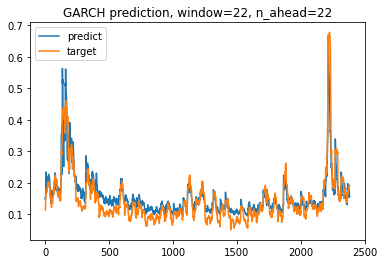

/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


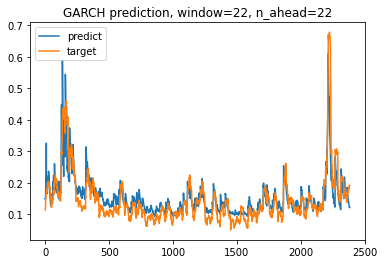

In [362]:

garch_estim = create_garch(data, target, window=22, n_ahead=22)
gjr_estim = create_gjr(data, target, window=22, n_ahead=22)
print(garch_estim)
print(gjr_estim)

In [363]:
data_g = data.copy()
data_g['GARCH'] = garch_estim['GARCH']
data_r = data.copy()
data_r['GJR'] = gjr_estim['GJR']
data_gr = data.copy()
data_gr['GJR'] = gjr_estim['GJR']
data_gr['GARCH'] = garch_estim['GARCH']

In [446]:
Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data_g, target, split_index, status=1,n_ahead=22, window=22)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405 entries, 0 to 2404
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2405 non-null   float64
 1   Log_Volume_change    2405 non-null   float64
 2   Daily_log_return     2405 non-null   float64
 3   Index                2405 non-null   float64
 4   gold                 2405 non-null   float64
 5   oil                  2405 non-null   float64
 6   GARCH                2383 non-null   float64
dtypes: float64(7)
memory usage: 131.6 KB
None
(1858, 22, 7)
(1858, 22, 1)
-----
(415, 22, 7)
(415, 22, 1)


In [447]:
data_g['GARCH']

0       0.151311
1       0.147852
2       0.152223
3       0.167637
4       0.173561
          ...   
2400         NaN
2401         NaN
2402         NaN
2403         NaN
2404         NaN
Name: GARCH, Length: 2405, dtype: float64

In [448]:
# model = create_lstm(0.6, output=22)
model = create_ann(output=22)
model_fit = model.fit(Xtrain, ytrain, batch_size=16, epochs=50)

Epoch 1/50
117/117 [==============================] - 1s 2ms/step - loss: 0.2750
Epoch 2/50
117/117 [==============================] - 0s 1ms/step - loss: 0.0866
Epoch 3/50
117/117 [==============================] - 0s 1ms/step - loss: 0.0663

In [449]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(1858, 22, 7)
(1858, 22, 1)
(415, 22, 7)
(415, 22, 1)


In [450]:
forecast = model.predict(Xtest)

In [451]:
forecast = forecast.mean(axis=1).reshape(len(forecast),1)
ytest = ytest.mean(axis=1).reshape(len(ytest),1)

print(forecast.shape)
print(ytest.shape)

(415, 1)
(415, 1)


In [452]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

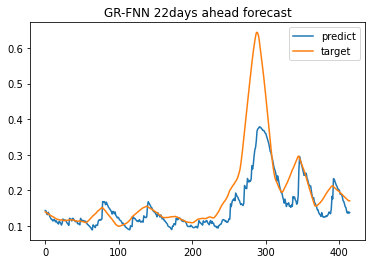

In [453]:
title = 'GR-FNN 22days ahead forecast'
plot(rev_forecast, rev_ytest, title, save=False)

In [454]:
evaluate(rev_forecast, rev_ytest, 'ANN')

--------ANN----------
test Score: 0.005576812235595784 MSE
test Score: 0.07467805725643767 RMSE
test Score: 0.16373952084517324 MAPE
test Score: 0.04028520261437379 MAE
test Score: 0.5766767284954744 R2 score
